# Bed Analysis by Z-Probe

This notebook calculate the gcode required to probe the Trium delta printer. In principle, the code can be adapted to any delta printer by appropriate changes to the contants.

The sample points are calculated on a regular grid according to the user-specified sampling density, plus a series of additional points near the towers and in the centre of the bed.  The points are carefully selected to present three points on lines partway to the tower. These three points correspond to the points on a smaller four-point test.  The idea is to use the detailed sampling less often and then use the four-point sample test for regular levelling.

## Repetier Logfile

It is somewhat of a mission to do a long multi-sample mesh probe with Repetier. For a few samples the log display on the screen is sufficiently large to capture all data.  However, for the 84-sample probe file created in here, the screen log area refreshes and loses some of the information. To capture the full log, you must use the Repetier log file on disk.  The procedure is as follows:

- Switch on the disk log file capture (by default is is off) using the Config/Preferences menu setting.
- Close Repetier to make the change effective.
- Execute the bed probing with the 84 sample file.
- Close Repetier again to force the completion of the log file writing to disk.
- Open the log file from disk in the directory `%USER%\AppData\Local\RepetierHost` ( you can change the location in the preferences setting.
- Cut the portion containing the information.


## Input data

The settings shown below were carefully tuned to achieve the following objectives:
- Keep the PWM fans clear of the Y and Z towers when probing.
- Keep the probe on the bed.
- Include the centre as a valid sample point.
- Include three sample points on a line between the centre and a tower, near a tower, such that the point can be compared with a simpler sampling procedure used for bed levelling.
- Give a reasonable sampling density at regular intervals.
- Do regular G28 homing commands. 



In [112]:
# to prepare and load constants

import numpy as np
from scipy.interpolate import interp2d
import scipy.linalg
import scipy.ndimage
import pyradi.ryplot as ryplot
import pandas as pd
import sys
import os
import os.path
import fnmatch
from sympy import Plane, Point3D,N,sympify,Line3D
from sympy.matrices import Matrix
import math

pd.set_option('precision', 3)

%matplotlib inline


np.set_printoptions(linewidth=120)
pd.set_option('display.width', 120)

bedRadius = 110. 
towerRadius = 180. # centre to belts
towerClearance = 70. # distance nozzle to outmost fan part
probeRadius = 104. # don't probe near edges
samplintx = 18.125 # sample interval in mm
samplinty = 22 # sample interval in mm
maxsize = 2.5 *  bedRadius  # number of points spread over this distance
xoffset = -33.5 # probe offset from nozzle
yoffset = -5. # probe offset from nozzle
numg28 = 2 # number of samples between g28 
numg30=5 # number of probes per one position

In [2]:
# to create the grid
x = np.arange(0,maxsize,samplintx)
x = np.sort(np.append(x,-x[1:]))
y = np.arange(0,maxsize,samplinty)
y = np.sort(np.append(y,-y[1:]))

# xx,yy are the required probe positions
xx,yy = np.meshgrid(x,y)
radius = np.sqrt(xx*xx+yy*yy)
# xn, yn are the nozzle positions corresponding to the above probe positions
xn = xx - xoffset
yn = yy - yoffset

# p = ryplot.Plotter(1,1,1,figsize=(8,7));
# p.meshContour(1,xx,yy,radius,contLabel=True,cbarshow=True);
# print(np.unique(xx))
# print(np.unique(yy))



The code below starts with a full and large grid of sampling points and then eliminates the illegal sample points.  Towards the Y tower some sampling points have to be dropped to prevent the fan from moving in into the Y-tower belt.

The gcode file created with this data set creates 84 samples over most of the bed.

In [3]:
# to eliminate the 'illegal' points
# Y tower, cutout around the tower by a sloping line, X limit and Y limit
coffset =  - (towerRadius-towerClearance) / np.tan(np.pi * 30. / 180.) 
slope = 2.
maskYs = yy >  slope*xx+coffset
maskYx = xx<50.
maskYy = yy>-30.
maskY =  np.logical_or( maskYs, np.logical_or(maskYy,maskYx))
# Z tower
maskZ = yy  <  towerRadius-towerClearance
# probe area within the head
maskB = radius <= probeRadius

# start with all possible points, then remove points below
valid = np.ones((xx.shape))
valid =  np.logical_and(valid,maskY)
valid =  np.logical_and(valid, maskZ) 
valid = np.logical_and(valid, maskB)

# create circles for plotting below
rang = np.linspace(0,2*np.pi,360)
xb = bedRadius * np.sin(rang)
yb = bedRadius * np.cos(rang)
xt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.sin(rang)
yt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.cos(rang)

print('unique probe x values:\n{}'.format(np.sort(np.unique(xx[valid]))))
print('unique probe y values:\n{}'.format(np.sort(np.unique(yy[valid]))))
print('unique nozzle x values:\n{}'.format(np.sort(np.unique(xn[valid]))))
print('unique nozzle y values:\n{}'.format(np.sort(np.unique(yn[valid]))))


unique probe x values:
[-90.625 -72.5   -54.375 -36.25  -18.125   0.     18.125  36.25   54.375  72.5    90.625]
unique probe y values:
[-88. -66. -44. -22.   0.  22.  44.  66.  88.]
unique nozzle x values:
[ -57.125  -39.     -20.875   -2.75    15.375   33.5     51.625   69.75    87.875  106.     124.125]
unique nozzle y values:
[-83. -61. -39. -17.   5.  27.  49.  71.  93.]


The following set of plots show the individual limits on the positioning in the gcode script.  The Y tower limit is the or of the slant, x and y limits because each of the limits individually are too severe.

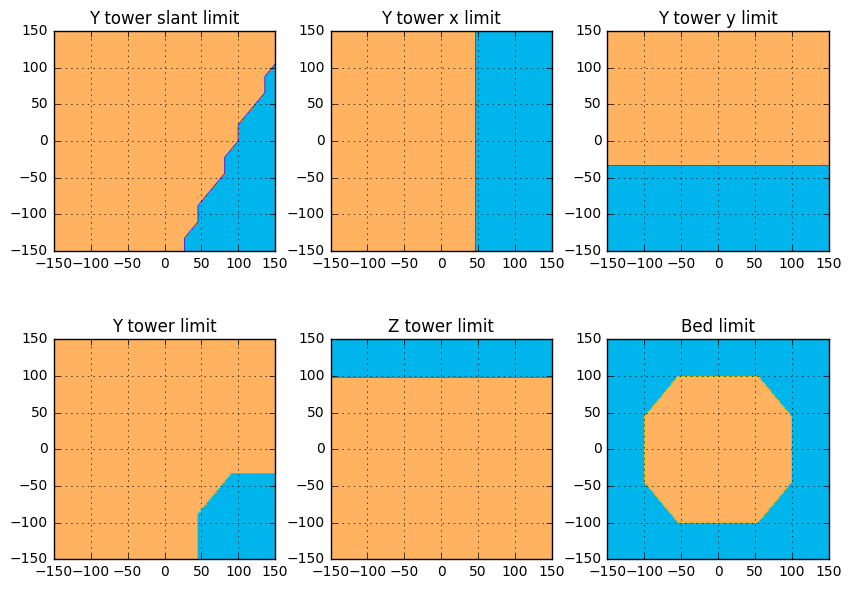

In [4]:
q = ryplot.Plotter(1,2,3,figsize=(10,7));
q.meshContour(1,xx,yy,maskYs,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower slant limit');
q.meshContour(2,xx,yy,maskYx,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower x limit');
q.meshContour(3,xx,yy,maskYy,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower y limit');
q.meshContour(4,xx,yy,maskY,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Y tower limit');
q.meshContour(5,xx,yy,maskZ,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Z tower limit');
q.meshContour(6,xx,yy,maskB,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Bed limit');


The following graphs show the final result, in probe position and nozzle position.  The gcode file is written using the nozzle position data.

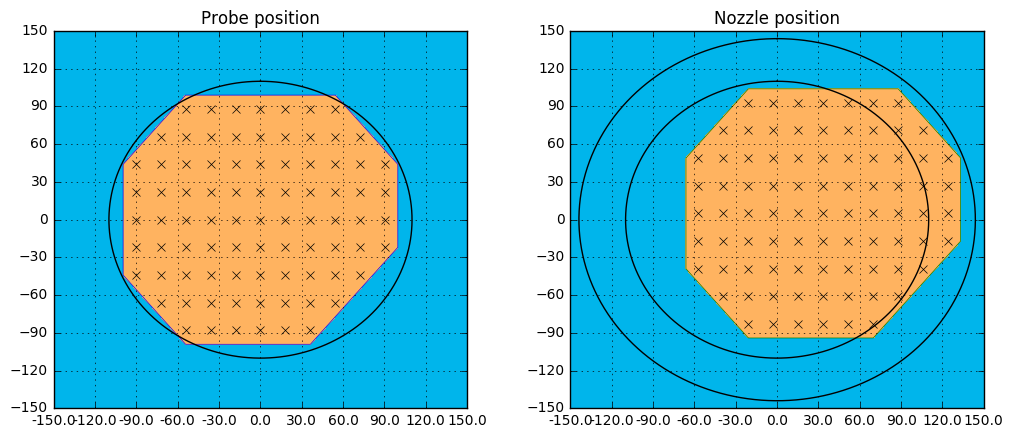

In [5]:

p = ryplot.Plotter(2,1,2,figsize=(12,5));

p.meshContour(1,xx,yy,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Probe position');
p.plot(1,xb,yb,plotCol=['k']);
p.plot(1,xx[valid],yy[valid],plotCol=['k'],markers=['x'],linestyle='');


p.meshContour(2,xx-xoffset,yy-yoffset,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Nozzle position');
p.plot(2,xb,yb,plotCol=['k']);
p.plot(2,xx[valid]-xoffset,yy[valid]-yoffset,plotCol=['k'],markers=['x'],linestyle='');
p.plot(2,xt,yt,plotCol=['k']);



Finally, the gcode file is written.

It was found that doing only one G28 homing at the start of the procedure is not sufficient, it leads to very large errors towards the end of the run (0.4 mm).  It takes a long time to G28 at every sample, but the present arrangement of G28 at every second sample appears to provide sufficient accuracy (but the procedure does takes a long time to do the frequent G28s).


In [6]:
# to write the gcode file
lst = []
for ix in range(0,xn.shape[0]):
    for iy in range(0,xn.shape[1]):
        if valid[ix,iy]:
            lst.append([xn[ix,iy],yn[ix,iy],xx[ix,iy],yy[ix,iy]])


df = pd.DataFrame(np.asarray(lst),columns=['xn','yn','xx','yy'])

header = """
;  probe the Trium bed in {} positions, {} times at each point
M119 ; print a separator in the log file
M105 ; get temperatures
G21  ; set units to mm
G90  ; absolute positioning
G28  ; home: reset coord sys by reading MAX endstops\n
""".format(df.shape[0],numg30)

footer = """
G28 ; home: reset coord sys by reading MAX endstops\n
"""

#note: we write nozzle position out here, not probe position
filename = 'g30-zprobe-{}-{}.gcode'.format(df.shape[0],numg30)
print('Writing {}'.format(filename))
with open(filename,'w') as fo:
    fo.write(header)
    for ie,idx in enumerate(df.index.values):
        strln = 'G0 X{:.3f} Y{:.3f} Z10 F3000\n'.format(df.ix[idx]['xn'],df.ix[idx]['yn'])
        fo.write(strln)
        for i in range(0,numg30):
            fo.write('G30\n')
        if not ie % numg28:
            fo.write('G28  ; home: reset coord sys by reading MAX endstops\n')
            
    fo.write(footer)

Writing g30-zprobe-84-5.gcode


After scanning the bed with the gcode file, the results are extracted from the Repetier log file (on disk) and placed in a new text file, read in and plotted.  The function below plots the results from the file.  For each position, the average is taken for all the samples at the specific point.

Time 18:24:41.747 
Bed temperature is 75.5 deg C
Nozzle temperature is 27.5 deg C

Measured bed:
x      -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38   72.50   76.50
y                                                                                            
-88.0     NaN     NaN  -0.220  -0.236  -0.186  -0.258  -0.242  -0.216     NaN     NaN     NaN
-66.0     NaN  -0.248  -0.264  -0.132  -0.254  -0.264  -0.270  -0.246  -0.190     NaN     NaN
-44.0  -0.050  -0.192  -0.096  -0.260  -0.210  -0.270  -0.290  -0.278  -0.240  -0.124     NaN
-22.0  -0.114  -0.212  -0.110  -0.234  -0.196  -0.238  -0.292  -0.284  -0.268  -0.170  -0.142
 0.0   -0.110  -0.010  -0.210  -0.130  -0.160  -0.210  -0.270  -0.290  -0.276  -0.198  -0.174
 22.0  -0.126  -0.070  -0.040  -0.116  -0.144  -0.188  -0.220  -0.256  -0.240  -0.140  -0.100
 44.0  -0.090  -0.020  -0.020  -0.090  -0.120  -0.172  -0.204  -0.218  -0.200  -0.058  -0.010
 66.0     NaN  -0.198   0.050  -0.064  -0.056  -0.146  -0

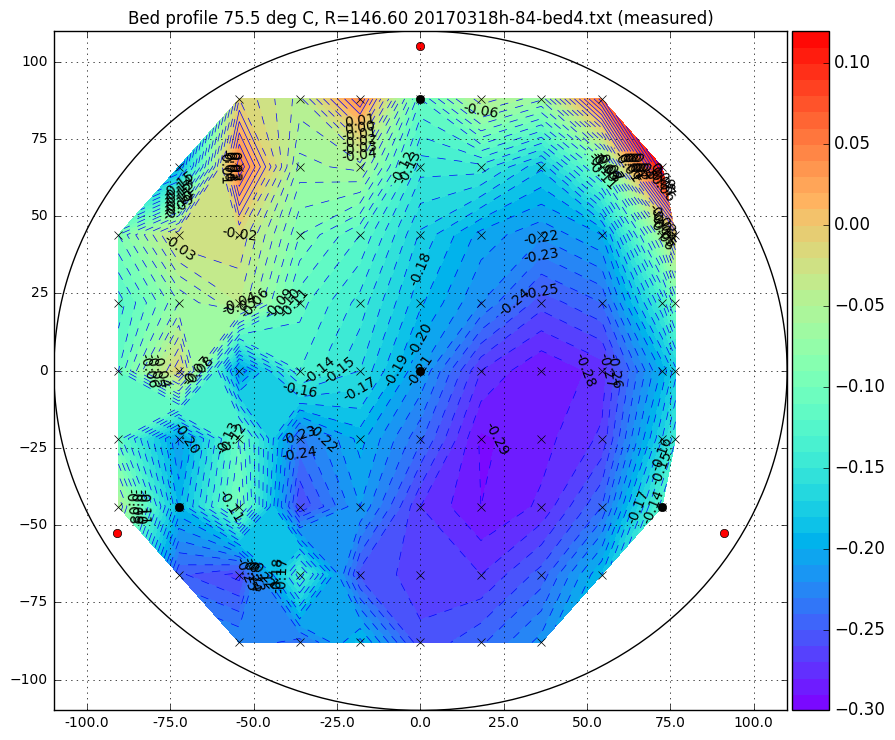

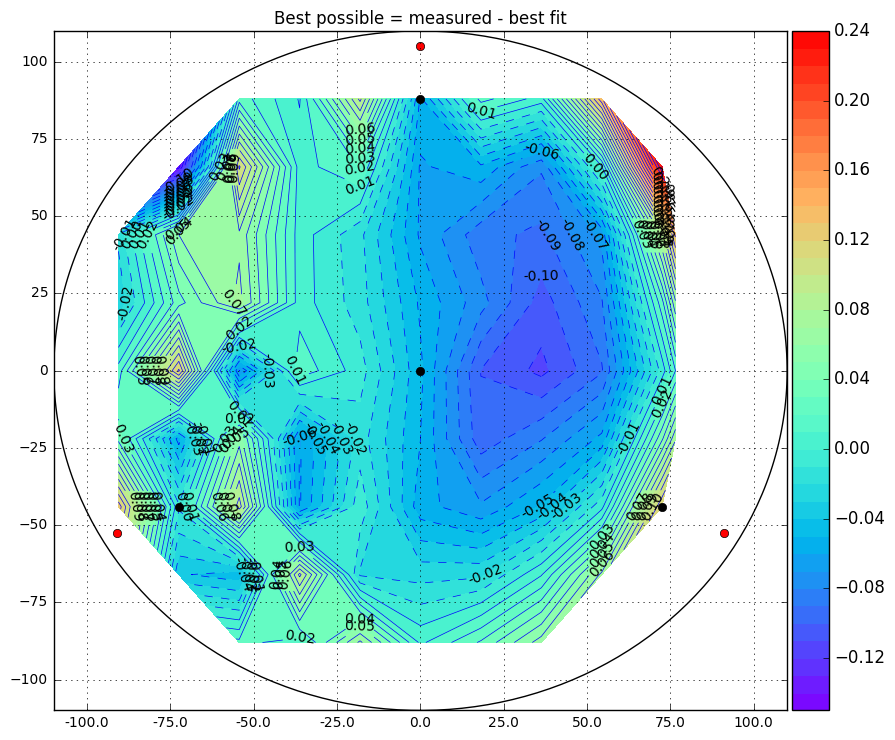

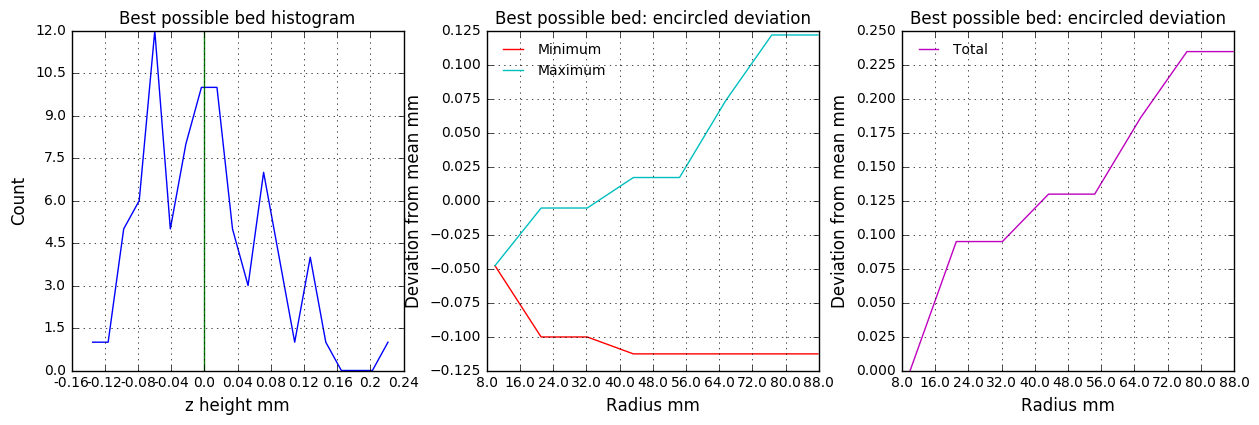

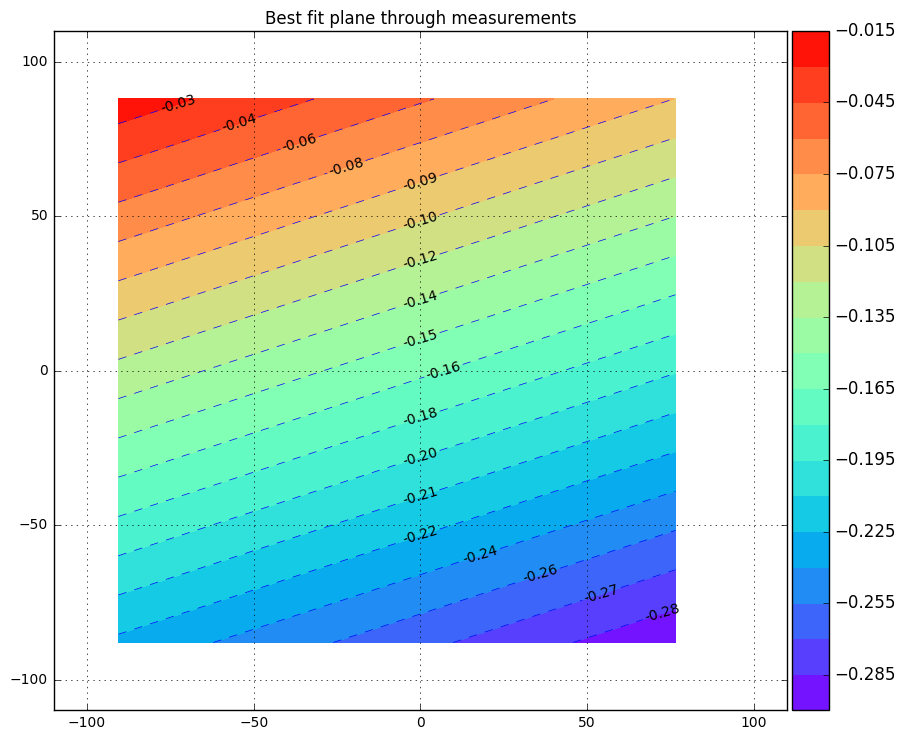

In [391]:
##
def highDensityBed(filename,zProbeTrigger,shimThickness,bedRadius=110.):
    validlines = []
    tdone = False
    bedtemp = ''
    with open(filename,'r') as fin:
        lines = fin.readlines()
        for line in lines:
            line = line.strip()
            if len(line)>3:
                if '>' in line[0] or '<' in line[0]:
                    line = line[2:]
                lstl = line.split(' ')
                # only use lines with Bed X: in them for dataframe
                if 'Bed X:' in line:
                    # remove unwanted clutter, keep only x,y,z
                    validlines.append([float(lstl[i]) for i in [4,6,8]])
                # if temperature lines, get values
                if not tdone and 'ok' in line and 'T:' in line and 'B:' in line:
                    print('Time {} '.format(lstl[0]))
                    bedtemp = lstl[5].split(':')[1]
                    print('Bed temperature is {} deg C'.format(bedtemp))
                    print('Nozzle temperature is {} deg C'.format(lstl[3].split(':')[1]))
                    tdone = True
                if 'M665' in line:
                    drad = lstl[6][1:]
    
    # here are the points used  
    calibsamples = np.asarray([[0,0],[-72.5,-44],[72.5,-44],[0,88]])
    screws = np.asarray([[0,105.],[-105*np.cos(np.pi/6.),-105*np.sin(np.pi/6.)],
                         [105*np.cos(np.pi/6.),-105*np.sin(np.pi/6.)]])
 
    # make pandas dataframe
    df = pd.DataFrame(validlines,columns=['x','y','z'])
    # the g30 command already corrected for the x,y offset
    # correct for probe offset and friction shim to get to metal
    df['z'] = df['z'] - (zProbeTrigger - shimThickness)
    
    dfr = df.groupby(by=['x','y']).aggregate(np.mean).reset_index().sort_values(by=['x','y'])
#     print(dfr)
#     print(dfr.columns)
#     print(np.max(dfr['z'])-np.min(dfr['z']))
    
    xUni = np.sort(dfr['x'].unique())
    yUni = np.sort(dfr['y'].unique())
    xUm,yUm = np.meshgrid(xUni,yUni)
    
    dfp = dfr.pivot(index='y', columns='x', values='z')
    print('\nMeasured bed:')
    print(dfp)
    
    # calculate a best-fit plane through the data points
    # https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6#file-curve_fitting-py
    A = np.c_[dfr['x'],dfr['y'],np.ones(dfr['y'].shape)]
    bfcoeff,_,_,_ = scipy.linalg.lstsq(A, dfr['z'])    # coefficients
    # evaluate best-fit-plane on grid
    bfplane = bfcoeff[0] * xUm + bfcoeff[1] * yUm  + bfcoeff[2]
    # substract the best fit plane to get 'corrected bed'
    # actually we should have rotated, this subtraction assumes small rotation angles
    bfcorrected = dfp.values - bfplane
    bfcorrected -= np.nanmean(bfcorrected.flatten())
    bfcorrected = pd.DataFrame(bfcorrected,columns=dfp.columns,index=dfp.index)
    
    #calculate the scew movement to take the bed to level
    # do this by calculating the bfplane height at the screws
    dfscrews = pd.DataFrame.from_dict({'x':[-72,72,0],'y':[-44,-44,105]})
    dfscrews.index = ['X','Y','Z']
    dfscrews['z'] = bfcoeff[0] * dfscrews['x'] + bfcoeff[1] * dfscrews['y']  + bfcoeff[2]
    
    print(dfscrews)
    
    
    
    
    # now get the max variation for circles around centre
    sradius = np.sqrt(xUm*xUm+yUm*yUm)
    tradiuss = np.linspace(10., 110., 10)
    minIntradius = np.zeros(tradiuss.shape)
    maxIntradius = np.zeros(tradiuss.shape)
    for i,tradius in enumerate(tradiuss):
        radialmask = sradius < tradius
        dradius = bfcorrected.values[radialmask]
        minIntradius[i] = np.min(np.min(dradius))
        maxIntradius[i] = np.max(np.max(dradius))

    dfpflat = bfcorrected.values.flatten()
    dfpflatnan = dfpflat[np.logical_not(np.isnan(dfpflat))]
    val, bins = np.histogram(dfpflatnan,bins=20)
    
    print('\nBest fit bed:')
    print('Best fit plane coefficients {}'.format(bfcoeff))
    print('Best fit corrected bed statistics: min={:.3f}  mean={:.3f}  max={:.3f} stddev={:.3f} spread={:.3f}\n'.format(
            np.nanmin(dfpflat),np.nanmean(dfpflat), np.nanmax(dfpflat), np.nanstd(dfpflat),
            np.nanmax(dfpflat)-np.nanmin(dfpflat)))
    if True:
        print(bfcorrected)

        
    # create circles for plotting below
    rang = np.linspace(0,2*np.pi,360)
    xb = bedRadius * np.sin(rang)
    yb = bedRadius * np.cos(rang)
    
    # measured data
    p = ryplot.Plotter(1,1,1,figsize=(10,9));
    p.meshContour(1,xUm,yUm,dfp,cbarshow=True,drawGrid=True,
                  levels=40,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Bed profile {} deg C, R={} {} (measured)'.format(bedtemp,drad,filename));

    p.plot(1,xb,yb,plotCol=['k']);
    p.plot(1,dfr['x'],dfr['y'],markers=['x'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);

    if False:
        #interpolate for plotting
        xi=xUm.ravel()              #Flat input into 1d vector
        xi=list(xi[xi!=np.isnan])   #eliminate any NaN
        yi=yUm.ravel()
        yi=list(yi[yi!=np.isnan])
        zi=dfp.values.ravel()
        zi=list(zi[zi!=np.isnan])
        from scipy.interpolate import griddata
        numinterp = 100
        xnew = np.linspace(-110.,110.,numinterp)
        ynew = np.linspace(-110.,110.,numinterp)
        znew = griddata((xi, yi), zi, (xnew[None,:], ynew[:,None]), method='linear')

        q = ryplot.Plotter(2,1,1,figsize=(10,9));
        q.meshContour(1,xnew,ynew,znew,cbarshow=True,drawGrid=True,
                      levels=40,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                      ptitle='Bed profile {} deg C, R={} {} (interpolated)'.format(bedtemp,drad,filename));

        q.plot(1,xb,yb,plotCol=['k']);
        q.plot(1,dfr['x'],dfr['y'],markers=['x'],linestyle='',plotCol=['k'],linewidths=[1]);
        q.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
        q.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);

    r = ryplot.Plotter(3,1,1,figsize=(10,9));
    r.meshContour(1,xUm,yUm,bfcorrected.values,cbarshow=True,drawGrid=True,
                  levels=40,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Best possible = measured - best fit'.format(bedtemp,drad,filename));
    r.plot(1,xb,yb,plotCol=['k']);
    r.plot(1,calibsamples[:,0],calibsamples[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);
    r.plot(1,screws[:,0],screws[:,1],markers=['o'],linestyle='',plotCol=['r'],linewidths=[1]);

    s = ryplot.Plotter(4,1,3,figsize=(15,4.5))
    s.plot(1,(bins[:-1]+bins[1:])/2., val)
    s.plot(1,np.asarray([np.nanmean(dfpflat),np.nanmean(dfpflat)]),np.asarray([0,np.max(val)]),
          'Best possible bed histogram','z height mm','Count')
    s.plot(2,tradiuss,minIntradius,label=['Minimum'])
    s.plot(2,tradiuss,maxIntradius,'Best possible bed: encircled deviation','Radius mm','Deviation from mean mm',label=['Maximum'])
    s.plot(3,tradiuss,maxIntradius-minIntradius,'Best possible bed: encircled deviation','Radius mm','Deviation from mean mm',label=['Total'])

    if True:
        # best fit plane corrected
        t = ryplot.Plotter(5,1,1,figsize=(10,9))
        t.meshContour(1,xUm,yUm,bfplane,cbarshow=True,drawGrid=True,
                      levels=20,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                      ptitle='Best fit plane through measurements');

    return xUm, yUm, dfp, bfplane, bfcorrected,bfcoeff, bedtemp    
    

    
xUm, yUm, dfp, bfplane,bfcorrected, bfcoeff, bedtemp = \
        highDensityBed('20170318h-84-bed4.txt',zProbeTrigger=0.7,shimThickness=0.1)
#         highDensityBed('20170313c-84-bed1.txt',zProbeTrigger=0.7,shimThickness=0.1)


In [358]:
# to determine the transformation between two sets of points
"""
http://nghiaho.com/?page_id=671
http://nghiaho.com/uploads/code/rigid_transform_3D.py_
http://stackoverflow.com/questions/20528094/computing-the-3d-transformation-between-two-sets-of-points
http://stackoverflow.com/questions/13432805/finding-translation-and-scale-on-two-sets-of-points-to-get-least-square-error-in
https://en.wikipedia.org/wiki/Kabsch_algorithm
https://github.com/charnley/rmsd
"""

def rigid_transform_3D(A, B):
    assert len(A) == len(B)
  
    N = A.shape[0]; # total points

    # get mean values 
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    H = (np.transpose(AA) * BB).T
#     H = AA * np.transpose(BB)

    U, S, Vt = scipy.linalg.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if scipy.linalg.det(R) < 0:
        print('Reflection detected')
        Vt[2,:] *= -1
        R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T

#     print t

    return R, t, centroid_A, centroid_B


In [359]:
def rigid_transform_3D(P, Q):
    assert len(P) == len(Q)

    # get centroid by mean values 
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    
    # centre the points
    P = P - np.tile(centroid_P, (P.shape[0], 1))
    Q = Q - np.tile(centroid_Q, (Q.shape[0], 1))
    
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)
    
    t = -U*centroid_P.T + centroid_Q.T

    return U, t, centroid_P, centroid_Q


In [369]:
################################################################################
# label the towers
def label_tower (row):
    # near X tower
    if row['x'] <-72. and row['x'] >-73. :
        if row['y'] < -43 and row['y']>-45:
            return 'X'
        else:
            return 'Xm'
    # near Y tower
    if row['x'] > 72. and row['x'] < 73. :
        if row['y'] < -43 and  row['y']>-45:
            return 'Y'
        else:
            return 'Ym'
    # near Z tower
    if row['y'] > 86. and row['x']<1 and row['x']>-1:
      return 'Z'
    if row['y'] < -86. and row['x']<1 and row['x']>-1:
      return 'Zm'
    return 'C'


################################################################################
# process one bed tower sample set
def lowDensityBed(filename,xUm, yUm,zhiin, bfcoeff, bedtemp,
                    zProbeTrigger=0.7,shimThickness=0.1):
    """Reads and analyse a file with four measured bed heights (near towers and in centre).

    The probe trigger z value (not the actual height) is determined by moving the hot end 
    slowly down and noting the z value where the probe triggers. The distance from the 
    nozzle tip to the probe trigger height is zProbeTrigger + shimThickness.


    The function calculates the number of screw turns required (on M3 screw) to move the 
    bed to z=0. This save us a little arithmetic and removes the confusion of which direction to move. 

          Args:
              | zProbeTrigger (float): the the z value when the probe triggers. 
              | shimThickness (float):  is the thickness of the paper/shim when doing the nozzle 
                friction test in mm.

          Returns:
              | the axis object for the plot

          Raises:
              | No exception is raised.
    """
    validlines = []
    tdone = False
    with open(filename,'r') as fin:
        lines = fin.readlines()
        for line in lines:
            if len(line) > 2:
                line = line.strip()
                if '>' in line[0] or '<' in line[0]:
                    line = line[2:]
                lstl = line.split(' ')
                # only use lines with Bed X: in them for dataframe
                if 'Bed X:' in line:
                    # remove unwanted clutter, keep only x,y,z
                    validlines.append([float(lstl[i]) for i in [4,6,8]])
                # if temperature lines, get values
                if not tdone and 'ok' in line and 'T:' in line and 'B:' in line:
                    print('Time {} '.format(lstl[0]))
                    print('Bed temperature is {} deg C'.format(lstl[5].split(':')[1]))
                    print('Nozzle temperature is {} deg C'.format(lstl[3].split(':')[1]))
                    tdone = True

    # make pandas dataframe
    zlopr = pd.DataFrame(validlines,columns=['x','y','zlopr'])
    # correct for probe offset and friction shim to get to metal
    zlopr['zlopr'] = zlopr['zlopr'] - (zProbeTrigger - shimThickness)
    zlopr['Tower'] = zlopr.apply(label_tower,axis=1)

    # from now on work with aggregates
    zlopr = zlopr.groupby(['Tower'])
    zlopr = zlopr.aggregate(np.mean)

    # unpivot to get xyz in columns
    zlopr.unstack()
    zhiinun = zhiin.unstack().reset_index(name='z').dropna(how='any').reset_index()
    
    # merge the dataframes
    dfm = pd.merge(zhiinun,zlopr,on=['x','y'], how='inner').drop(['index'],axis=1).rename(columns = {'z':'zhiin'})
    # name the rows
    dfm['Tower'] = dfm.apply(label_tower,axis=1)
    print(dfm)
    
    print('zhiin = high density sample set (84)')

    # now calculate the transformation between the two low density samples
    target = dfm[['x','y','zhiin']].values
    presnt = dfm[['x','y','zlopr']].values
#     print(target)
#     print(presnt)
#     R, t, centA, centP = rigid_transform_3D(np.mat(presnt), np.mat(target) )
    R, t, centA, centP = rigid_transform_3D(np.mat(target), np.mat(presnt) )
    print(R)
    print(t)
    print(centA)
    print(centP)
#     dftx = pd.DataFrame(((R * presnt.T)).T,columns=['x','y','R*Zhiin'] )
    dftx = pd.DataFrame(((R * presnt.T)+ np.tile(t, (1,))).T,columns=['x','y','R*Zhiin'] )
    for col in ['x','y']:
        dftx[col] = np.round(dftx[col],1)
    dfm = pd.merge(dfm,dftx,on=['x','y'], how='inner')
   
    print(dfm)
    print(dfm['R*Zhiin']-dfm['zlopr'])

lowDensityBed(filename='20170318i-7-bed4.txt',xUm=xUm, yUm=yUm, zhiin=bfcorrected, 
              bfcoeff=bfcoeff, bedtemp=bedtemp)

Time 19:37:36.512 
Bed temperature is 73.9 deg C
Nozzle temperature is 27.0 deg C
      x     y  zhiin  zlopr Tower
0 -72.5 -44.0 -0.008 -0.102     X
1 -72.5  44.0  0.060  0.022    Xm
2   0.0 -88.0  0.008 -0.306    Zm
3   0.0   0.0 -0.048 -0.272     C
4   0.0  88.0 -0.052  0.090     Z
5  72.5 -44.0  0.120 -0.076     Y
6  72.5  44.0  0.082  0.000    Ym
zhiin = high density sample set (84)
[[  9.99999872e-01   1.00553693e-06  -5.06531482e-04]
 [  3.12933053e-08   9.99997905e-01   2.04691744e-03]
 [  5.06532479e-04  -2.04691719e-03   9.99997777e-01]]
[[  1.17809689e-05]
 [ -4.76074472e-05]
 [ -1.15258066e-01]]
[[ 0.          0.          0.02325812]]
[[ 0.     0.    -0.092]]
      x     y  zhiin  zlopr Tower  R*Zhiin
0 -72.5 -44.0 -0.008 -0.102     X   -0.164
1 -72.5  44.0  0.060  0.022    Xm   -0.220
2   0.0 -88.0  0.008 -0.306    Zm   -0.241
3   0.0   0.0 -0.048 -0.272     C   -0.387
4   0.0  88.0 -0.052  0.090     Z   -0.205
5  72.5 -44.0  0.120 -0.076     Y   -0.064
6  72.5  44.0  0.08

# Bed levelling 

At present we have a detailed set of bed profile measurements, the high density measurements (HDM) of 84 samples.  This measurement will not be repeated often, because it takes a long time. The HDM provides a very good indication of a level bed in a statistical sense.  We want to use this HDM information, but with fewer G30 samples in subsequent bed level procedures.


## Algorithm

To optimally level the bed from a small low density measurement (LDM) data set, say 2x2 or 3x3 samples, do the following:

Step 1. Align the initial HDM bed profile with the later LDM measurement. Do this by transforming the HDM data set (zhiin) to best align/fit the few samples in the low density measurement (zlopr) of the present bed. This gives us a high density equivalent of the present bed (zhipr) - as if we measured the present full bed in high density.  If we rigidly transform (rotate and translate) all the data points in the original HDM data set by best fit matching only the data points common to both HDM zhiin and LDM zlopr, we can assume that zhipr is a good representation of the full bed in the present orientation.

Step 2. Calculate the best fit plane (zbfpr) through newly calculated titled high density bed estimate (zhipr).   This best fit plane zbfpr must now be levelled to achieve a statistically level bed. 

Step 3. Find the difference between zlopr and zbfpr in the screw: this gives the movement required to move the present bed to level.


## Step 1 Transformting zhiin to zhipr

From [here](http://nghiaho.com/?page_id=671):  Finding the optimal/best rotation and translation between two sets of corresponding 3D point data, so that they are aligned/registered.

We’re solving for $R$, and $t$ in the equation:

$$B = R*A + t$$

Where $R$, $t$ are the transforms applied to dataset $A$ to align it with dataset $B$, as best as possible.

Finding the optimal rigid transformation matrix can be broken down into the following steps:

### Step 1.1 Find the centroids of both datasets. 

The centroids are just the average point and can be calculated as follows:

$$P = \left[\begin{array}{c} x\\ y\\ z \end{array}\right]$$

$$centroid_A = \frac{1}{N} \displaystyle\sum\limits_{i=1}^N P_A^i$$

$$centroid_B = \frac{1}{N} \displaystyle\sum\limits_{i=1}^N P_B^i$$

Here, $P_A$ and $P_B$ are points in dataset $A$ and $$B respectively. We will use these values in the next step.

### Step 1.2 Bring both dataset to the origin then find the optimal rotation, (matrix $R$)

The SVD will decompose/factorise a matrix (call it $E$), into 3 other matrices, such that:

$$[U,S,V] = SVD(E)$$

$$E = USV^T$$

If $E$ is a square matrix then $U$, $S$ and $V$ are the same size as well. We’re only interested in square matrices for this problem so I won’t go into detail about rectangular ones.

To find the optimal rotation we first re-centre both dataset so that both centroids are at the origin, like shown below

This removes the translation component, leaving on the rotation to deal with. The next step involves accumulating a matrix, called $H$, and using SVD to find the rotation as follows:

$$H = \displaystyle\sum\limits_{i=1}^N (P_A^i - centroid_A)(P_B^i - centroid_B)^T$$

$$[U,S,V] = SVD(H)$$

$$R = VU^T$$

$H$ is the familiar covariance matrix.

At this point you may be thinking, “what the, that easy?!”, and indeed you would be right. One thing to be careful is that you calculate H correctly. It should end up being a 3×3 matrix, not a 1×1 matrix. Pay close attention to the transpose symbol. It’s doing a multiplication between 2 matrices where the dimensions effectively are, 3×1 and 1×3, respectively. The ordering of the multiplication is also important, doing it the other way will find a rotation from B to A instead.

There’s a special case when finding the rotation matrix that you have to take care of. Sometimes the SVD will return a ‘reflection’ matrix, which is numerically correct but is actually nonsense in real life. This is addressed by checking the determinant of R (from SVD above) and seeing if it’s negative (-1). If it is then the 3rd column of V is multiplied by -1.

### Step 1.3: Find the translation $t$

$$t = -R \times centroid_A + centroid_B$$

The centroids are 3×1 column vectors.

How did I get this? If you remember back, to transform $A$ to $B$ we first had to centre $A$ to its origin. This is where the $-centroid_A$ comes from, though I put the minus sign at the front. We then rotate $A$, hence $R$. Then finally translate it to dataset $B$’s origin, the $+ centroid_B$ bit

The solution presented can be used on any size dataset as long as there are at least 3 points. When there are more than 3 points a least square solution is obtained, such that the following error is minimised:

$$err = \displaystyle\sum\limits_{i=1}^N \left|\left|RP_A^i + t -P_B^i \right|\right|^2$$

Here, the operator $||$  $||$ is the Euclidean distance between two vectors, a scalar value. $err$ is just the square distance error between the points in the two dataset.


